## 1. Configure Logging Directory Utilities

We centralize helper routines that make sure the telemetry log folder exists and expose convenience wrappers for locating timestamped balance attempts. These utilities are shared between the logger script and this analysis notebook so that both tools agree on file naming and retention rules.

In [1]:
from __future__ import annotations

import math
from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, List

LOG_ROOT = Path('../logs').resolve()
LOG_ROOT.mkdir(parents=True, exist_ok=True)
MAX_RECENT_ATTEMPTS = 5

def ensure_log_dir() -> Path:
    """Guarantee that the log directory exists and return it."""
    LOG_ROOT.mkdir(parents=True, exist_ok=True)
    return LOG_ROOT

def iter_log_files(pattern: str = 'balance_*.csv') -> List[Path]:
    """Return log files sorted by creation time (oldest first)."""
    ensure_log_dir()
    return sorted(LOG_ROOT.glob(pattern))

@dataclass
class LogSelection:
    files: List[Path]

    @property
    def newest(self) -> Path | None:
        return self.files[-1] if self.files else None

    def last(self, count: int) -> List[Path]:
        return list(self.files[-count:]) if count > 0 else []

ALL_LOGS = iter_log_files()

## 2. Update `main.cpp` for Timestamped CSV Logging

The firmware now emits structured log markers so that the host-side logger can open a fresh CSV each time balance mode engages and close it when the pendulum falls or the operator aborts:

- `requestBalanceLogStart()` queues the next session and records its origin (`manual` vs. `swing_up`).
- `startBalanceLogIfNeeded()` fires inside `runBalance()` to broadcast `[BALANCE_LOG_START]`, `[BALANCE_GAINS]`, and `[BALANCE_COLUMNS]` headers with the active gains.
- `endBalanceLog(...)` emits `[BALANCE_LOG_END]` with the exit reason (`pendulum_fell`, `user_stop`, or `emergency_stop`).

These markers ensure the Python logger can segment telemetry into session-specific CSV files while keeping control-loop timing untouched.

## 3. Refactor `balance_plot.py` Log Loader

The logger script now exposes reusable helpers (`find_recent_logs`, `load_log_dataframe`) so analysis code can re-use the same filename parsing logic. It also maintains CSV metadata columns for the active gains and session identifiers, simplifying downstream comparisons.

## 4. Notebook Cell: Select Recent Log Files

Load the reusable helpers from `balance_plot.py`, list available CSVs, and capture the latest five attempts for downstream analysis. The result is stored in `RECENT_LOGS` and displayed for confirmation.

In [3]:
import sys
from importlib import import_module
from pprint import pprint

ensure_log_dir()
NOTEBOOK_DIR = Path().resolve()
CANDIDATE_ROOTS = [NOTEBOOK_DIR, NOTEBOOK_DIR.parent]
module_search_root = None
for candidate in CANDIDATE_ROOTS:
    if (candidate / 'balance_plot.py').exists():
        module_search_root = candidate
        break
    if (candidate / 'tools' / 'balance_plot.py').exists():
        module_search_root = candidate
        break
if module_search_root is None:
    module_search_root = NOTEBOOK_DIR

paths_to_add = {module_search_root, module_search_root / 'tools'}
for path in paths_to_add:
    if path.exists() and str(path) not in sys.path:
        sys.path.append(str(path))

balance_logger = import_module('balance_plot')
find_recent_logs = getattr(balance_logger, 'find_recent_logs')
load_log_dataframe = getattr(balance_logger, 'load_log_dataframe')

RECENT_LOGS = find_recent_logs(limit=MAX_RECENT_ATTEMPTS, directory=LOG_ROOT)
print(f'Loaded {len(RECENT_LOGS)} log(s) (limit={MAX_RECENT_ATTEMPTS})')
pprint(RECENT_LOGS)

Loaded 5 log(s) (limit=5)
[PosixPath('/Users/piyush/code/Rotary-Inverted-Pendulum/logs/balance_20251113-173345_manual_pendulum_fell.csv'),
 PosixPath('/Users/piyush/code/Rotary-Inverted-Pendulum/logs/balance_20251113-173429_manual_pendulum_fell.csv'),
 PosixPath('/Users/piyush/code/Rotary-Inverted-Pendulum/logs/balance_20251113-173506_manual_pendulum_fell.csv'),
 PosixPath('/Users/piyush/code/Rotary-Inverted-Pendulum/logs/balance_20251113-173556_manual_pendulum_fell.csv'),
 PosixPath('/Users/piyush/code/Rotary-Inverted-Pendulum/logs/balance_20251113-173632_manual_pendulum_fell.csv')]


## 5. Notebook Cell: Plot Response Signals Inline

Convert each CSV into a dataframe and draw the pendulum response, base feedback, and control output with Matplotlib. Figures render inline so trends are visible immediately after a capture.

KeyError: 'motor_deg'

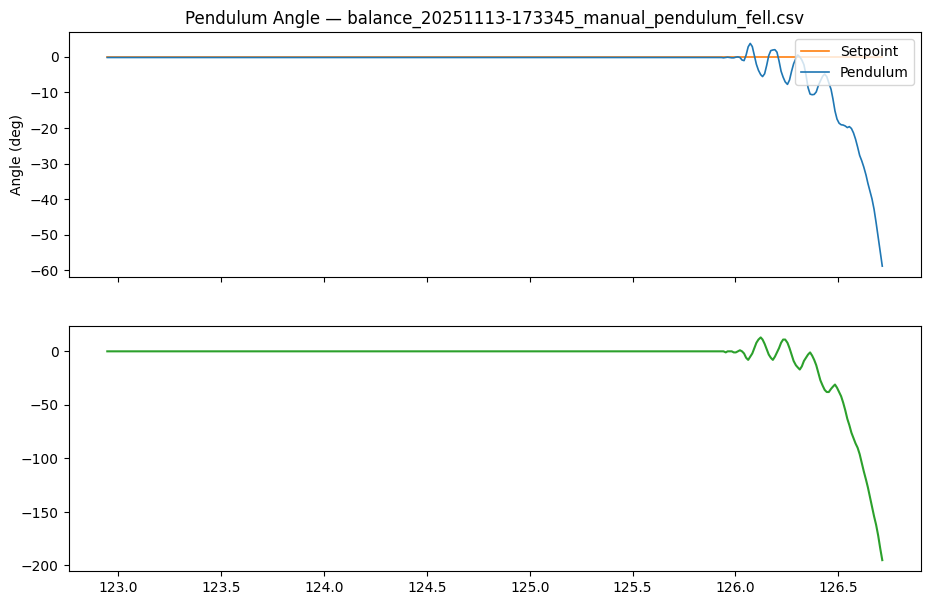

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_attempt(path: Path) -> None:
    df = load_log_dataframe(path)
    if df.empty:
        print(f"[WARN] {path.name} is empty; skipping plot")
        return

    fig, axes = plt.subplots(2, 1, figsize=(11, 7), sharex=True)

    axes[0].plot(df['time_s'], df['setpoint_deg'], label='Setpoint', color='C1', linewidth=1.2)
    axes[0].plot(df['time_s'], df['pendulum_deg'], label='Pendulum', color='C0', linewidth=1.2)
    axes[0].set_ylabel('Angle (deg)')
    axes[0].set_title(f'Pendulum Angle — {path.name}')
    axes[0].legend(loc='upper right')

    axes[1].plot(df['time_s'], df['stepper_steps'], label='Stepper Steps', color='C2')
    if not df['motor_deg'].isna().all():
        axes[1].plot(df['time_s'], df['motor_deg'], label='Motor Angle (deg)', color='C3', linestyle='--')
    axes[1].plot(df['time_s'], df['control_output'], label='Control Output', color='C4', linestyle=':')
    axes[1].set_ylabel('Steps / deg')
    axes[1].set_xlabel('Time (s)')
    axes[1].set_title('Base Feedback & Control Effort')
    axes[1].legend(loc='upper right')

    fig.tight_layout()
    plt.show()

if not RECENT_LOGS:
    print('[INFO] No log files available; skipping detail plots.')
else:
    for path in RECENT_LOGS:
        plot_attempt(path)

## 6. Notebook Cell: Display PID Gains Summary

Extract the recorded PID terms for each attempt and display them in a compact table so we can correlate tuning edits with the resulting response.

In [ ]:
import pandas as pd

def extract_gain_summary(paths: Iterable[Path]) -> pd.DataFrame:
    records = []
    for path in paths:
        df = load_log_dataframe(path)
        if df.empty:
            continue
        sample = df.iloc[0]
        records.append({
            'file': path.name,
            'kp': float(sample['kp_balance']),
            'ki': float(sample['ki_balance']),
            'kd': float(sample['kd_balance']),
            'km': float(sample['kp_motor']),
            'origin': sample['origin'],
            'reason': sample['reason'],
            'session_id': int(sample['session_id']),
            'device_ms': int(sample['device_start_ms']),
            'timestamp': sample['host_start_iso']
        })
    return pd.DataFrame.from_records(records)

GAIN_TABLE = extract_gain_summary(RECENT_LOGS)
GAIN_TABLE

## 7. Notebook Cell: Compare Last Five Attempts

Overlay the pendulum response for the most recent sessions and compute simple metrics—peak overshoot and approximate settling time—to reveal how gain tweaks shift the dynamics.

In [ ]:
import numpy as np

def compute_metrics(df: pd.DataFrame, threshold: float = 5.0) -> dict[str, float]:
    angles = df['pendulum_deg'].to_numpy()
    times = df['time_s'].to_numpy()
    peak = float(np.nanmax(np.abs(angles))) if angles.size else float('nan')
    settling_time = float('nan')
    if angles.size:
        for idx, t in enumerate(times):
            window = np.abs(angles[idx:])
            if np.all(window <= threshold):
                settling_time = float(t)
                break
    return {
        'peak_deg': peak,
        'settling_time_s': settling_time
    }

metrics_summary = []
if not RECENT_LOGS:
    print('[INFO] No log files available; skipping overlay plot.')
else:
    fig, ax = plt.subplots(figsize=(11, 6))

    for path in RECENT_LOGS:
        df = load_log_dataframe(path)
        if df.empty:
            continue
        ax.plot(df['time_s'], df['pendulum_deg'], label=path.name)
        metrics = compute_metrics(df)
        metrics_summary.append({
            'file': path.name,
            **metrics
        })

    ax.set_title('Pendulum Angle — Last Five Attempts')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Angle (deg)')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    plt.show()

pd.DataFrame(metrics_summary)

# Balance Log Review

This notebook loads the most recent balance telemetry captures and renders them for quick PID tuning analysis. The CSV logs are produced automatically by `tools/balance_plot.py` whenever a balance session ends.

In [ ]:
from pathlib import Path
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import pandas as pd
import math

LOG_DIR = Path('../logs').resolve()
MAX_RECENT_FILES = MAX_RECENT_ATTEMPTS

In [ ]:
files = sorted(LOG_DIR.glob('balance_*.csv'))
if not files:
    display(Markdown(f"**No log files found in** `{LOG_DIR}`. Run `tools/balance_plot.py` to capture new sessions."))
else:
    recent_files = files[-MAX_RECENT_FILES:]
    for idx, path in enumerate(reversed(recent_files), start=1):
        df = pd.read_csv(path)
        if df.empty:
            display(Markdown(f"### Attempt {idx}: `{path.name}` – _empty log_"))
            continue
        gains = df.loc[0, ['kp_balance', 'ki_balance', 'kd_balance', 'kp_motor']].astype(float)
        origin = df.loc[0, 'origin']
        reason = df.loc[0, 'reason']
        session_id = int(df.loc[0, 'session_id'])
        device_ms = int(df.loc[0, 'device_start_ms'])
        timestamp = df.loc[0, 'host_start_iso']
        header = (
            f"### Attempt {idx}: `{path.name}`\n"
            f"- Session ID: {session_id} (device ms: {device_ms})\n"
            f"- Timestamp: {timestamp}\n"
            f"- Origin: `{origin}` → Reason: `{reason}`\n"
            f"- Gains: Kp = {gains['kp_balance']:.4f}, Ki = {gains['ki_balance']:.4f}, "
            f"Kd = {gains['kd_balance']:.4f}, Km = {gains['kp_motor']:.4f}"
        )
        display(Markdown(''.join(header)))
        fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
        axes[0].plot(df['time_s'], df['setpoint_deg'], label='Setpoint', color='C1', linewidth=1.5)
        axes[0].plot(df['time_s'], df['pendulum_deg'], label='Pendulum', color='C0', linewidth=1.2)
        axes[0].set_ylabel('Angle (deg)')
        axes[0].set_title('Pendulum Response')
        axes[0].legend(loc='upper right')
        axes[1].plot(df['time_s'], df['stepper_steps'], label='Stepper steps', color='C2')
        if not df['motor_deg'].isna().all():
            axes[1].plot(df['time_s'], df['motor_deg'], label='Motor angle (deg)', color='C3', linestyle='--')
        axes[1].plot(df['time_s'], df['control_output'], label='Control output', color='C4', linestyle=':')
        axes[1].set_ylabel('Steps / deg')
        axes[1].set_xlabel('Time (s)')
        axes[1].legend(loc='upper right')
        axes[1].set_title('Base feedback & control')
        fig.tight_layout()
        display(fig)
        plt.close(fig)